In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.simplefilter("ignore", category=UserWarning)

import os
os.environ['OMP_NUM_THREADS'] = '1'


In [2]:
df = pd.read_csv('updated_dataset (1).csv')

In [3]:
df.columns

Index(['ID', 'Age', 'Gender', 'Race', 'BMI', 'Date of Admission',
       'Date of Hospital Discharge', 'PEG', 'TRACH', 'PEG ORDERS PLACED',
       'TRACH ORDERS PLACED', 'PEG DATE', 'TRACH DATE', 'PEG TIME',
       'TRACH TIME', 'PEG SERVICE', 'TRACH SERVICE', 'Discharge Disposition',
       'Discharge Status Code', 'GCS', 'GCS Qualifier', 'ISS',
       '#CO-MORBIDITIES', 'ICU LOS Days', 'Hospital LOS Days',
       '#Of total complications', 'Date Decannulation', 'Date of oral intake',
       'Date of Death', 'Date of readmission', 'Comorbidities List',
       'Charlson_Comorbidity_Index', 'DischargeGCS', 'VAP',
       'Total_Neutrophils', 'Total_Lymphocytes', 'NLR'],
      dtype='object')

# Classification

In [4]:
#  dataset
df = pd.read_csv('updated_dataset (1).csv')

#  date columns to datetime
date_columns = ['Date of Admission', 'Date of Hospital Discharge', 'PEG ORDERS PLACED', 'TRACH ORDERS PLACED', 'PEG DATE', 'TRACH DATE', 'Date Decannulation', 'Date of oral intake']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Drop rows where 'Hospital LOS Days' is less than 0
df = df[df['Hospital LOS Days'] >= 0]

#  differences in days
df['PEG_Duration'] = (df['Date of oral intake'] - df['PEG DATE']).dt.days
df['PEG_Days_Difference'] = (df['PEG DATE'] - df['PEG ORDERS PLACED']).dt.days
df['PEG_ORDER_to_ADMISSION'] = (df['PEG ORDERS PLACED'] - df['Date of Admission']).dt.days
df['Trach_ORDER_to_ADMISSION'] = (df['TRACH ORDERS PLACED'] - df['Date of Admission']).dt.days
df['Trach_Days_Difference'] = (df['TRACH DATE'] - df['TRACH ORDERS PLACED']).dt.days
df['Trach_Duration'] = (df['Date Decannulation'] - df['TRACH DATE']).dt.days

# Categorize 'Hospital LOS'
df['Hospital_LOS_Category'] = pd.cut(df['Hospital LOS Days'],
                                         bins=[-np.inf, 24, np.inf],
                                         labels=[0, 1])


# Selected features
features = ['Age', 'Gender', 'Race', 'BMI', 'PEG', 'TRACH', 'GCS', 
            'ISS', 'Charlson_Comorbidity_Index'
            ]
X = df[features]
y = df['Hospital_LOS_Category']

# Encode categorical features
categorical_features = ['Gender', 'Race', 'PEG', 'TRACH']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Age', 'BMI', 'GCS', 'ISS', 'Charlson_Comorbidity_Index']),
        ('cat', OneHotEncoder(), categorical_features)])


In [5]:
y.value_counts()

Hospital_LOS_Category
1    199
0     64
Name: count, dtype: int64

In [6]:
df.columns

Index(['ID', 'Age', 'Gender', 'Race', 'BMI', 'Date of Admission',
       'Date of Hospital Discharge', 'PEG', 'TRACH', 'PEG ORDERS PLACED',
       'TRACH ORDERS PLACED', 'PEG DATE', 'TRACH DATE', 'PEG TIME',
       'TRACH TIME', 'PEG SERVICE', 'TRACH SERVICE', 'Discharge Disposition',
       'Discharge Status Code', 'GCS', 'GCS Qualifier', 'ISS',
       '#CO-MORBIDITIES', 'ICU LOS Days', 'Hospital LOS Days',
       '#Of total complications', 'Date Decannulation', 'Date of oral intake',
       'Date of Death', 'Date of readmission', 'Comorbidities List',
       'Charlson_Comorbidity_Index', 'DischargeGCS', 'VAP',
       'Total_Neutrophils', 'Total_Lymphocytes', 'NLR', 'PEG_Duration',
       'PEG_Days_Difference', 'PEG_ORDER_to_ADMISSION',
       'Trach_ORDER_to_ADMISSION', 'Trach_Days_Difference', 'Trach_Duration',
       'Hospital_LOS_Category'],
      dtype='object')

### XGBoost


In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier

#  dataset
df = pd.read_csv('updated_dataset (1).csv')

#  date columns to datetime
date_columns = ['Date of Admission', 'Date of Hospital Discharge', 'PEG ORDERS PLACED', 'TRACH ORDERS PLACED', 'PEG DATE', 'TRACH DATE', 'Date Decannulation', 'Date of oral intake']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Drop rows where 'Hospital LOS Days' is less than 0
df = df[df['Hospital LOS Days'] >= 0]

#  differences in days
df['PEG_Duration'] = (df['Date of oral intake'] - df['PEG DATE']).dt.days
df['PEG_Days_Difference'] = (df['PEG DATE'] - df['PEG ORDERS PLACED']).dt.days
df['PEG_ORDER_to_ADMISSION'] = (df['PEG ORDERS PLACED'] - df['Date of Admission']).dt.days
df['Trach_ORDER_to_ADMISSION'] = (df['TRACH ORDERS PLACED'] - df['Date of Admission']).dt.days
df['Trach_Days_Difference'] = (df['TRACH DATE'] - df['TRACH ORDERS PLACED']).dt.days
df['Trach_Duration'] = (df['Date Decannulation'] - df['TRACH DATE']).dt.days

# Categorize 'Hospital LOS'
df['Hospital_LOS_Category'] = pd.cut(df['Hospital LOS Days'],
                                         bins=[-np.inf, 24, np.inf],
                                         labels=[0, 1])


# Selected features
features = ['Age', 'Gender', 'Race', 'BMI', 'PEG', 'TRACH', 'GCS', 
            'ISS', 'Charlson_Comorbidity_Index'
            ]
X = df[features]
y = df['Hospital_LOS_Category']

# Encode categorical features
categorical_features = ['Gender', 'Race', 'PEG', 'TRACH']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Age', 'BMI', 'GCS', 'ISS', 'Charlson_Comorbidity_Index']),
        ('cat', OneHotEncoder(), categorical_features)])


# XGBoost model
XGB_model = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1,
    random_state=42
)

# Pipeline including SMOTE 
XGB_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', XGB_model)
])

#  GridSearchCV 
param_grid = {
    'model__n_estimators': [50, 100, 200, 500],
    'model__learning_rate': [0.001, 0.01, 0.1, 0.3],
    'model__max_depth': [3, 5, 7, 10],
    # 'model__min_child_weight': [1, 3, 5, 7],
    'model__gamma': [0, 0.1, 0.2, 0.3],
    'model__subsample': [0.6, 1.0],
    # 'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__reg_alpha': [0, 0.01, 0.1, 1],
    'model__reg_lambda': [0.1, 1, 10]
}

#  StratifiedKFold cross-validator
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#  grid search
grid_search = GridSearchCV(XGB_pipeline, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X, y)

best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")


# Evaluate 
XGB_y_pred = grid_search.predict(X)
XGB_y_prob = grid_search.predict_proba(X)[:, 1]
print("Classification Report:")
print(classification_report(y, XGB_y_pred))


roc_auc = roc_auc_score(y, XGB_y_prob)
print(f"AUC Score: {roc_auc:.4f}")


f1 = f1_score(y, XGB_y_pred, average='weighted')
print(f"F1 Score: {f1:.4f}")


print("Confusion Matrix:")
print(confusion_matrix(y, XGB_y_pred))


Fitting 5 folds for each of 6144 candidates, totalling 30720 fits
Best Parameters: {'model__gamma': 0.3, 'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 200, 'model__reg_alpha': 0.1, 'model__reg_lambda': 0.1, 'model__subsample': 1.0}
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.72      0.64        64
           1       0.90      0.83      0.87       199

    accuracy                           0.81       263
   macro avg       0.74      0.78      0.76       263
weighted avg       0.82      0.81      0.81       263

AUC Score: 0.8775
F1 Score: 0.8125
Confusion Matrix:
[[ 46  18]
 [ 33 166]]


In [8]:

# Evaluate 
XGB_y_pred = grid_search.predict(X)
XGB_y_prob = grid_search.predict_proba(X)[:, 1]
print("Classification Report:")
print(classification_report(y, XGB_y_pred))


roc_auc = roc_auc_score(y, XGB_y_prob)
print(f"AUC Score: {roc_auc:.4f}")


f1 = f1_score(y, XGB_y_pred, average='weighted')
print(f"F1 Score: {f1:.4f}")


print("Confusion Matrix:")
print(confusion_matrix(y, XGB_y_pred))

accuracy = accuracy_score(y, XGB_y_pred)
print(f"Accuracy: {accuracy:.4f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.72      0.64        64
           1       0.90      0.83      0.87       199

    accuracy                           0.81       263
   macro avg       0.74      0.78      0.76       263
weighted avg       0.82      0.81      0.81       263

AUC Score: 0.8775
F1 Score: 0.8125
Confusion Matrix:
[[ 46  18]
 [ 33 166]]
Accuracy: 0.8061


### SVR

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.svm import SVC

#  dataset
df = pd.read_csv('updated_dataset (1).csv')

#  date columns to datetime
date_columns = ['Date of Admission', 'Date of Hospital Discharge', 'PEG ORDERS PLACED', 'TRACH ORDERS PLACED', 'PEG DATE', 'TRACH DATE', 'Date Decannulation', 'Date of oral intake']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Drop rows where 'Hospital LOS Days' is less than 0
df = df[df['Hospital LOS Days'] >= 0]

#  differences in days
df['PEG_Duration'] = (df['Date of oral intake'] - df['PEG DATE']).dt.days
df['PEG_Days_Difference'] = (df['PEG DATE'] - df['PEG ORDERS PLACED']).dt.days
df['PEG_ORDER_to_ADMISSION'] = (df['PEG ORDERS PLACED'] - df['Date of Admission']).dt.days
df['Trach_ORDER_to_ADMISSION'] = (df['TRACH ORDERS PLACED'] - df['Date of Admission']).dt.days
df['Trach_Days_Difference'] = (df['TRACH DATE'] - df['TRACH ORDERS PLACED']).dt.days
df['Trach_Duration'] = (df['Date Decannulation'] - df['TRACH DATE']).dt.days

# Categorize 'Hospital LOS'
df['Hospital_LOS_Category'] = pd.cut(df['Hospital LOS Days'],
                                         bins=[-np.inf, 24, np.inf],
                                         labels=[0, 1])


# Selected features
features = ['Age', 'Gender', 'Race', 'BMI', 'PEG', 'TRACH', 'GCS', 
            'ISS', 'Charlson_Comorbidity_Index'
            ]
X = df[features]
y = df['Hospital_LOS_Category']

# Encode categorical features
categorical_features = ['Gender', 'Race', 'PEG', 'TRACH']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Age', 'BMI', 'GCS', 'ISS', 'Charlson_Comorbidity_Index']),
        ('cat', OneHotEncoder(), categorical_features)])

# Define the SVC model
svm_model = SVC(probability=True, random_state=42)

# Pipeline including SMOTE for handling imbalance
SVM_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', svm_model)
])

# Define the parameter grid for GridSearchCV
SVM_param_grid = {
    'model__C': [0.1, 1, 10, 100],
    'model__kernel': ['linear', 'rbf'],
    'model__gamma': ['scale', 'auto', 0.01, 0.001],
    'model__class_weight': [None, 'balanced']
}

# Cross-validation setup (5-fold)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform GridSearchCV
grid_search = GridSearchCV(SVM_pipeline, SVM_param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X, y)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Evaluate the best model
# Ensure predictions are aligned
SVM_y_prob = grid_search.predict_proba(X)[:, 1]  # Full dataset predictions
SVM_y_pred = grid_search.predict(X)


# Print evaluation metrics
print("Classification Report:")
print(classification_report(y, SVM_y_pred))

roc_auc = roc_auc_score(y, SVM_y_prob)
print(f"AUC Score: {roc_auc:.4f}")

f1 = f1_score(y, SVM_y_pred, average='weighted')
print(f"F1 Score: {f1:.4f}")

print("Confusion Matrix:")
print(confusion_matrix(y, SVM_y_pred))
accuracy = accuracy_score(y, SVM_y_pred)
print(f"Accuracy: {accuracy:.4f}")



Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best Parameters: {'model__C': 0.1, 'model__class_weight': None, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.75      0.52        64
           1       0.89      0.64      0.74       199

    accuracy                           0.67       263
   macro avg       0.64      0.69      0.63       263
weighted avg       0.77      0.67      0.69       263

AUC Score: 0.7703
F1 Score: 0.6889
Confusion Matrix:
[[ 48  16]
 [ 72 127]]
Accuracy: 0.6654


In [10]:
len(SVM_y_pred)

263

### ANN

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score, classification_report, confusion_matrix, accuracy_score
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Load dataset
df = pd.read_csv('updated_dataset (1).csv')

# Convert date columns to datetime
date_columns = [
    'Date of Admission', 'Date of Hospital Discharge', 'PEG ORDERS PLACED', 'TRACH ORDERS PLACED',
    'PEG DATE', 'TRACH DATE', 'Date Decannulation', 'Date of oral intake'
]
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Drop rows where 'Hospital LOS Days' is less than 0
df = df[df['Hospital LOS Days'] >= 0]

# Feature engineering
df['PEG_Duration'] = (df['Date of oral intake'] - df['PEG DATE']).dt.days
df['PEG_Days_Difference'] = (df['PEG DATE'] - df['PEG ORDERS PLACED']).dt.days
df['PEG_ORDER_to_ADMISSION'] = (df['PEG ORDERS PLACED'] - df['Date of Admission']).dt.days
df['Trach_ORDER_to_ADMISSION'] = (df['TRACH ORDERS PLACED'] - df['Date of Admission']).dt.days
df['Trach_Days_Difference'] = (df['TRACH DATE'] - df['TRACH ORDERS PLACED']).dt.days
df['Trach_Duration'] = (df['Date Decannulation'] - df['TRACH DATE']).dt.days

# Create binary target for classification
df['Hospital_LOS_Category'] = pd.cut(df['Hospital LOS Days'], bins=[-np.inf, 24, np.inf], labels=[0, 1])

# Define input features and target variable
features = ['Age', 'Gender', 'Race', 'BMI', 'PEG', 'TRACH', 'GCS', 'ISS', 'Charlson_Comorbidity_Index']
X = df[features]
y = df['Hospital_LOS_Category'].astype(int)

# Preprocessing: Standardize numerical features and one-hot encode categorical features
categorical_features = ['Gender', 'Race', 'PEG', 'TRACH']
numerical_features = ['Age', 'BMI', 'GCS', 'ISS', 'Charlson_Comorbidity_Index']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

X = preprocessor.fit_transform(X)

# Define the ANN model
def create_ann_model(hidden_units=64, dropout_rate=0.3, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(hidden_units, input_dim=X.shape[1], activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(hidden_units // 2, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrap ANN model using KerasClassifier
ann_model = KerasClassifier(
    model=create_ann_model,
    random_state=42,
    verbose=0
)

# Define parameter grid for GridSearchCV
param_grid = {
    'model__hidden_units': [32, 64, 128],     # Number of units in the first hidden layer
    'model__dropout_rate': [0.2, 0.3, 0.4],  # Dropout rate for regularization
    'model__learning_rate': [0.001, 0.01],   # Learning rate for optimization
    'batch_size': [16, 32],                  # Batch size during training
    'epochs': [50, 100]                      # Number of epochs for training
}

# Perform GridSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=ann_model, param_grid=param_grid, cv=cv, scoring='roc_auc', verbose=2, n_jobs=-1)
grid_search.fit(X, y)

# Get the best parameters and the best model
print(f"Best Parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

# Evaluate the best ANN model on the full dataset
ANN_y_prob = best_model.predict_proba(X)[:, 1]
ANN_y_pred = (ANN_y_prob > 0.5).astype(int)

print("Classification Report (Full Dataset):")
print(classification_report(y, ANN_y_pred))

roc_auc = roc_auc_score(y, ANN_y_prob)
print(f"AUC Score (Full Dataset): {roc_auc:.4f}")

f1 = f1_score(y, ANN_y_pred, average='weighted')
print(f"F1 Score (Full Dataset): {f1:.4f}")

print("Confusion Matrix (Full Dataset):")
print(confusion_matrix(y, ANN_y_pred))

accuracy = accuracy_score(y, SVM_y_pred)
print(f"Accuracy: {accuracy:.4f}")



Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'batch_size': 16, 'epochs': 50, 'model__dropout_rate': 0.3, 'model__hidden_units': 64, 'model__learning_rate': 0.001}
Classification Report (Full Dataset):
              precision    recall  f1-score   support

           0       0.83      0.47      0.60        64
           1       0.85      0.97      0.91       199

    accuracy                           0.85       263
   macro avg       0.84      0.72      0.75       263
weighted avg       0.85      0.85      0.83       263

AUC Score (Full Dataset): 0.8788
F1 Score (Full Dataset): 0.8316
Confusion Matrix (Full Dataset):
[[ 30  34]
 [  6 193]]
Accuracy: 0.6654


In [66]:
import tensorflow as tf
import shap
import numpy as np

# Extract the Keras model from KerasClassifier
best_keras_model = best_model.model_

# Build the model with a dummy input
input_shape = X_transformed.shape[1]  # Number of features
dummy_input = np.zeros((1, input_shape))  # Create a dummy input with the correct shape
best_keras_model(dummy_input)  # Build the model

# Wrap the model as a callable TensorFlow/Keras Model object
wrapped_model = tf.keras.Model(inputs=best_keras_model.input, outputs=best_keras_model.output)

# SHAP KernelExplainer setup (fallback)
explainer = shap.KernelExplainer(wrapped_model.predict, X_transformed[:50])  # Use a subset for initialization

# Compute SHAP values
shap_values = explainer.shap_values(X_transformed[:100])  # Calculate SHAP values for a subset

# Visualize SHAP summary plot
shap.summary_plot(shap_values, X_transformed[:100], feature_names=numerical_features + list(preprocessor.named_transformers_['cat'].categories_))


AttributeError: The layer sequential has never been called and thus has no defined input.

In [12]:
len(ANN_y_prob)

263

In [19]:
from tensorflow.keras.utils import plot_model

# Visualize the ANN Model
def visualize_ann_model(model):
    plot_model(
        model,
        to_file="ann_model.png",  # Saves the model visualization as a file
        show_shapes=True,         # Displays the shapes of layers
        show_layer_names=True     # Shows layer names
    )
    print("ANN model visualization saved as ann_model.png")

# Example Usage
visualize_ann_model(create_ann_model())


ANN model visualization saved as ann_model.png


In [22]:
from graphviz import Digraph

def visualize_detailed_ann():
    dot = Digraph(format="png", graph_attr={"rankdir": "LR"})
    
    # Input Layer
    input_layer_nodes = [f"Input {i}" for i in range(1, 17)]  # 16 features
    for node in input_layer_nodes:
        dot.node(node, shape="circle", style="filled", color="lightblue")
    
    # First Hidden Layer (64 neurons)
    hidden_layer_1_nodes = [f"H1_{i}" for i in range(1, 65)]
    for node in hidden_layer_1_nodes:
        dot.node(node, shape="circle", style="filled", color="lightgreen")
    
    # Second Hidden Layer (32 neurons)
    hidden_layer_2_nodes = [f"H2_{i}" for i in range(1, 33)]
    for node in hidden_layer_2_nodes:
        dot.node(node, shape="circle", style="filled", color="yellow")
    
    # Output Layer (1 neuron)
    dot.node("Output", shape="circle", style="filled", color="red")
    
    # Add connections
    # From Input Layer to First Hidden Layer
    for i_node in input_layer_nodes:
        for h1_node in hidden_layer_1_nodes:
            dot.edge(i_node, h1_node, arrowhead="vee")
    
    # From First Hidden Layer to Second Hidden Layer
    for h1_node in hidden_layer_1_nodes:
        for h2_node in hidden_layer_2_nodes:
            dot.edge(h1_node, h2_node, arrowhead="vee")
    
    # From Second Hidden Layer to Output Layer
    for h2_node in hidden_layer_2_nodes:
        dot.edge(h2_node, "Output", arrowhead="vee")
    
    # Render and save
    dot.render("ann_detailed_visualization", cleanup=True)
    print("Detailed ANN visualization saved as 'ann_detailed_visualization.png'")

# Run the visualization function
visualize_detailed_ann()


Detailed ANN visualization saved as 'ann_detailed_visualization.png'


## Diversity

In [25]:
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error
from scipy.stats import pearsonr

# Bootstrap sampling function
def bootstrap_sample(X, y, n_samples=5):
    np.random.seed(42)
    indices = [np.random.choice(range(len(y)), size=len(y), replace=True) for _ in range(n_samples)]
    return indices

# Bias-Variance Calculation
def calculate_bias_variance_with_risk(models, X, y, n_samples=5):
    indices = bootstrap_sample(X, y, n_samples)
    predictions = {model_name: [] for model_name in models}

    for idx_set in indices:
        X_train, y_train = X[idx_set], y[idx_set]
        for model_name, model in models.items():
            model.fit(X_train, y_train)
            predictions[model_name].append(model.predict(X))

    bias_variance_risk = {}
    for model_name, preds in predictions.items():
        preds = np.array(preds)
        avg_pred = preds.mean(axis=0)
        bias = np.mean((avg_pred - y) ** 2)
        variance = np.mean(np.var(preds, axis=0))
        diversity = np.mean([np.var([pred for pred in preds]) for pred in preds.T])
        expected_risk = bias + variance - diversity

        bias_variance_risk[model_name] = {
            'bias': bias,
            'variance': variance,
            'diversity': diversity,
            'expected_risk': expected_risk,
        }
    return bias_variance_risk

# Diversity Calculation
def calculate_diversity(models, X, y):
    predictions = {}
    for model_name, model in models.items():
        predictions[model_name] = model.predict(X)
    
    diversity_metrics = {}
    model_names = list(models.keys())
    for i, model1 in enumerate(model_names):
        for j, model2 in enumerate(model_names):
            if i < j:
                # Disagreement Measure
                disagree = np.mean(predictions[model1] != predictions[model2])
                # Correlation Coefficient
                corr, _ = pearsonr(predictions[model1], predictions[model2])
                # Q-Statistic
                q_stat = (np.sum(predictions[model1] == y) * np.sum(predictions[model2] == y) - 
                          np.sum(predictions[model1] != y) * np.sum(predictions[model2] != y))
                q_stat /= len(y) ** 2

                diversity_metrics[f"{model1} vs {model2}"] = {
                    'disagreement': disagree,
                    'correlation': corr,
                    'q_statistic': q_stat
                }
    return diversity_metrics

# Example Usage
models = {
    'XGBoost': XGB_model,
    'SVM': svm_model,
    'ANN': ann_model  # Ensure ann_model is wrapped appropriately for scikit-learn
}

# Bias-Variance Analysis
bias_variance_results = calculate_bias_variance_with_risk(models, X, y)
print("Bias-Variance Results:")
print(bias_variance_results)

# Diversity Analysis
diversity_results = calculate_diversity(models, X, y)
print("Diversity Results:")
print(diversity_results)


Bias-Variance Results:
{'XGBoost': {'bias': 0.04243346007604563, 'variance': 0.0617490494296578, 'diversity': 0.1706174731454842, 'expected_risk': -0.06643496363978077}, 'SVM': {'bias': 0.1464638783269962, 'variance': 0.04897338403041826, 'diversity': 0.10046928537350544, 'expected_risk': 0.09496797698390902}, 'ANN': {'bias': 0.24653992395437263, 'variance': 0.017338403041825098, 'diversity': 0.07090690916451012, 'expected_risk': 0.1929714178316876}}
Diversity Results:
{'XGBoost vs SVM': {'disagreement': 0.155893536121673, 'correlation': 0.46112075161730315, 'q_statistic': 0.6996197718631179}, 'XGBoost vs ANN': {'disagreement': 0.22433460076045628, 'correlation': 0.10380874542621221, 'q_statistic': 0.6387832699619772}, 'SVM vs ANN': {'disagreement': 0.10646387832699619, 'correlation': 0.01050733182608466, 'q_statistic': 0.5437262357414449}}


In [48]:
from sklearn.base import clone

# Snapshot + Dropout Ensemble
def snapshot_dropout_ensemble(base_model, X, y, n_snapshots=5, dropout_rate=0.3):
    snapshots = []
    for i in range(n_snapshots):
        # Clone and apply dropout for each snapshot
        model = clone(base_model)
        if hasattr(model, 'dropout_rate'):
            model.dropout_rate = dropout_rate  # Ensure ANN model adjusts dropout rate
        model.fit(X, y)
        snapshots.append(model)
    return snapshots

# Predict using Snapshot Ensemble
def snapshot_predict(snapshots, X):
    predictions = np.array([model.predict(X) for model in snapshots])
    return predictions.mean(axis=0)

# Weighted Averaging Ensemble
def weighted_average_ensemble(models, weights, X):
    predictions = np.array([model.predict_proba(X)[:, 1] for model in models])
    return np.dot(weights, predictions)

# Example: XGBoost + ANN Weighted Ensemble
weights = [0.6, 0.4]
models = [XGB_model, ann_model]
ensemble_probs = weighted_average_ensemble(models, weights, X)
ensemble_preds = (ensemble_probs > 0.5).astype(int)

# Evaluate
print("Weighted Averaging Ensemble:")
print(classification_report(y, ensemble_preds))
print(f"AUC Score: {roc_auc_score(y, ensemble_probs):.4f}")

f1 = f1_score(y, ensemble_preds, average='weighted')
print(f"F1 Score (Full Dataset): {f1:.4f}")

print("Confusion Matrix (Full Dataset):")
print(confusion_matrix(y, ensemble_preds))

accuracy = accuracy_score(y, ensemble_preds)
print(f"Accuracy: {accuracy:.4f}")


Weighted Averaging Ensemble:
              precision    recall  f1-score   support

           0       0.84      0.72      0.77        64
           1       0.91      0.95      0.93       199

    accuracy                           0.90       263
   macro avg       0.87      0.84      0.85       263
weighted avg       0.89      0.90      0.89       263

AUC Score: 0.8755
F1 Score (Full Dataset): 0.8946
Confusion Matrix (Full Dataset):
[[ 46  18]
 [  9 190]]
Accuracy: 0.8973


In [49]:
# Weighted Averaging with SVM
weights = [0.5, 0.3, 0.2]  # Adjusted for XGBoost, ANN, and SVM
models = [XGB_model, ann_model, svm_model]
weighted_probs = weighted_average_ensemble(models, weights, X)
weighted_preds = (weighted_probs > 0.5).astype(int)

print("Weighted Averaging Ensemble with SVM:")
print(classification_report(y, weighted_preds))
print(f"AUC Score: {roc_auc_score(y, weighted_probs):.4f}")


f1 = f1_score(y, weighted_preds, average='weighted')
print(f"F1 Score (Full Dataset): {f1:.4f}")

print("Confusion Matrix (Full Dataset):")
print(confusion_matrix(y, weighted_preds))

accuracy = accuracy_score(y, weighted_preds)
print(f"Accuracy: {accuracy:.4f}")

Weighted Averaging Ensemble with SVM:
              precision    recall  f1-score   support

           0       0.85      0.72      0.78        64
           1       0.91      0.96      0.94       199

    accuracy                           0.90       263
   macro avg       0.88      0.84      0.86       263
weighted avg       0.90      0.90      0.90       263

AUC Score: 0.8732
F1 Score (Full Dataset): 0.8982
Confusion Matrix (Full Dataset):
[[ 46  18]
 [  8 191]]
Accuracy: 0.9011


In [50]:
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, classification_report, confusion_matrix

# Generate Snapshot Ensembles for ANN
snapshots_ann = snapshot_dropout_ensemble(ann_model, X, y, n_snapshots=50, dropout_rate=0.5)

# Predict probabilities for Snapshot + Dropout Ensemble
snapshot_probs = snapshot_predict(snapshots_ann, X)  # Directly get probabilities

# Convert probabilities to class predictions
snapshot_preds = (snapshot_probs > 0.5).astype(int)

# Calculate Metrics
snapshot_auc = roc_auc_score(y, snapshot_probs)
snapshot_f1 = f1_score(y, snapshot_preds, average="weighted")
snapshot_accuracy = accuracy_score(y, snapshot_preds)
snapshot_conf_matrix = confusion_matrix(y, snapshot_preds)

# Print Classification Report
print("Snapshot + Dropout Ensemble Metrics:")
print(f"AUC Score: {snapshot_auc:.4f}")
print(f"F1 Score: {snapshot_f1:.4f}")
print(f"Accuracy: {snapshot_accuracy:.4f}")
print("Confusion Matrix:")
print(snapshot_conf_matrix)

# Full Classification Report
print("\nFull Classification Report:")
print(classification_report(y, snapshot_preds))

accuracy = accuracy_score(y, snapshot_preds)
print(f"Accuracy: {accuracy:.4f}")


Snapshot + Dropout Ensemble Metrics:
AUC Score: 0.5296
F1 Score: 0.6848
Accuracy: 0.7452
Confusion Matrix:
[[  7  57]
 [ 10 189]]

Full Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.11      0.17        64
           1       0.77      0.95      0.85       199

    accuracy                           0.75       263
   macro avg       0.59      0.53      0.51       263
weighted avg       0.68      0.75      0.68       263

Accuracy: 0.7452


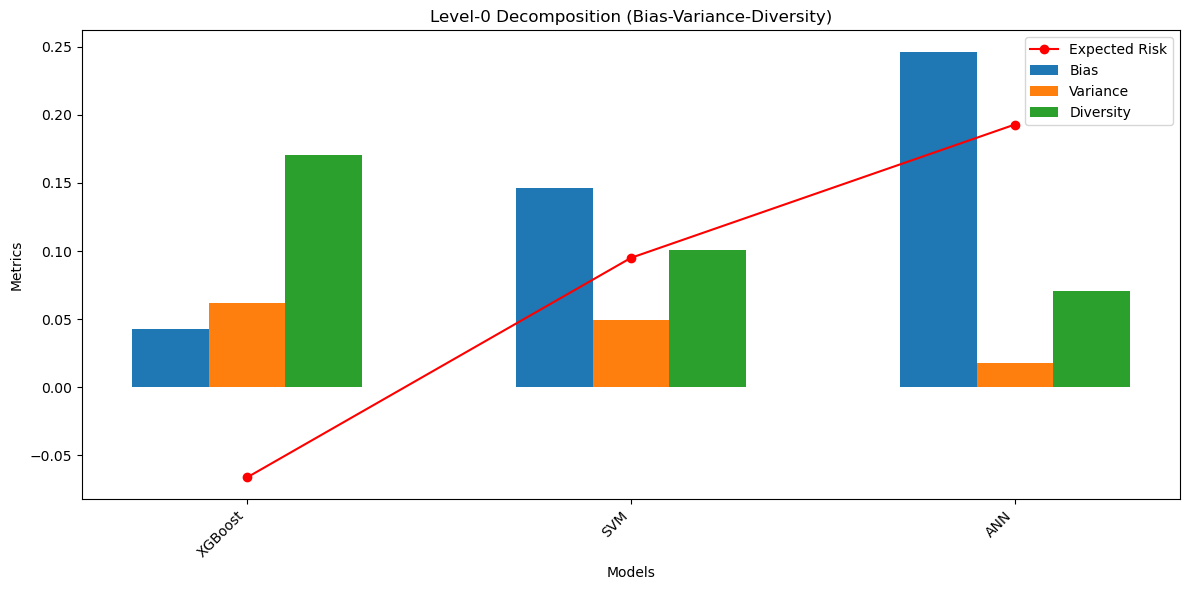

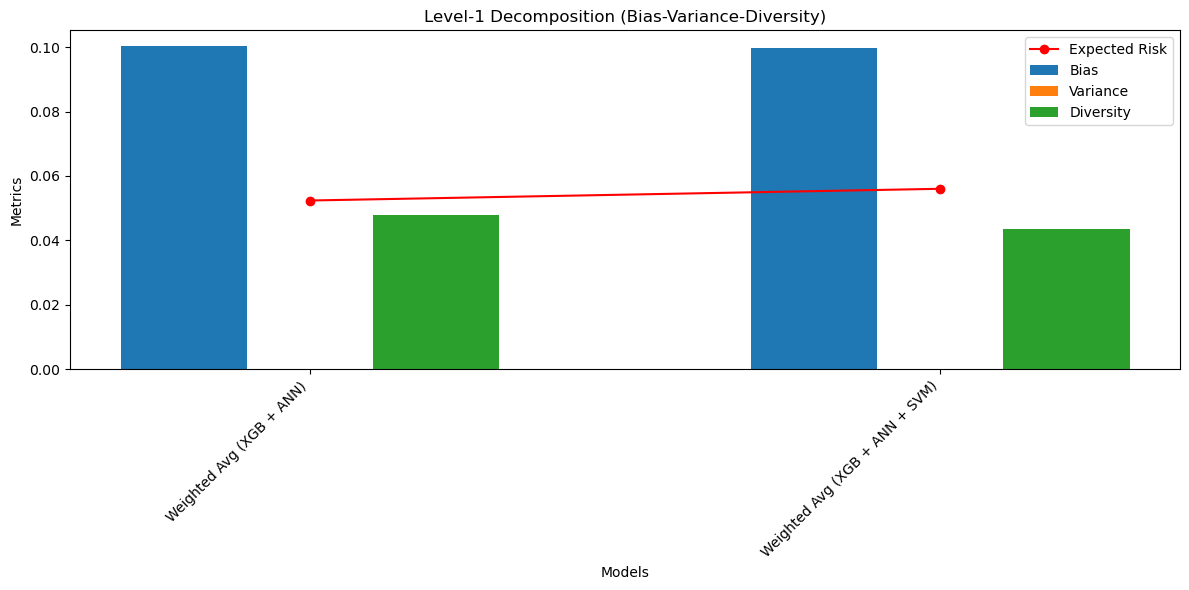

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.metrics import roc_auc_score, classification_report, f1_score, confusion_matrix

# Bootstrap Sampling Function
def bootstrap_sample(X, y, n_samples=5):
    np.random.seed(42)
    indices = [np.random.choice(len(y), size=len(y), replace=True) for _ in range(n_samples)]
    return indices

# Bias-Variance-Diversity Decomposition Function for Level-0 Models
def calculate_decomposition(models, X, y, n_samples=5):
    indices = bootstrap_sample(X, y, n_samples)
    predictions = {model_name: [] for model_name in models}

    for idx_set in indices:
        X_train, y_train = X[idx_set], y[idx_set]
        for model_name, model in models.items():
            model_clone = clone(model)
            model_clone.fit(X_train, y_train)
            predictions[model_name].append(model_clone.predict(X))

    results = {}
    for model_name, preds in predictions.items():
        preds = np.array(preds)
        avg_pred = preds.mean(axis=0)
        bias = np.mean((avg_pred - y) ** 2)
        variance = np.mean(np.var(preds, axis=0))
        diversity = np.mean([np.var([pred for pred in preds]) for pred in preds.T])
        expected_risk = bias + variance - diversity

        results[model_name] = {
            'bias': bias,
            'variance': variance,
            'diversity': diversity,
            'expected_risk': expected_risk
        }
    return results

# Decomposition Function for Level-1 Ensembles
def calculate_decomposition_level_1(models, X, y, n_samples=5):
    indices = bootstrap_sample(X, y, n_samples)
    results = {}
    
    for model_name, model_func in models.items():
        predictions = []
        for idx_set in indices:
            X_train, y_train = X[idx_set], y[idx_set]
            predictions.append(model_func(X))  # Use the ensemble function directly
            
        preds = np.array(predictions)
        avg_pred = preds.mean(axis=0)
        bias = np.mean((avg_pred - y) ** 2)
        variance = np.mean(np.var(preds, axis=0))
        diversity = np.mean([np.var([pred for pred in preds]) for pred in preds.T])
        expected_risk = bias + variance - diversity
        
        results[model_name] = {
            'bias': bias,
            'variance': variance,
            'diversity': diversity,
            'expected_risk': expected_risk
        }
    return results

# Visualization Function
def plot_decomposition(results, title):
    categories = list(results.keys())
    bias = [results[cat]['bias'] for cat in categories]
    variance = [results[cat]['variance'] for cat in categories]
    diversity = [results[cat]['diversity'] for cat in categories]
    risk = [results[cat]['expected_risk'] for cat in categories]

    x = np.arange(len(categories))
    width = 0.2

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width, bias, width, label='Bias')
    ax.bar(x, variance, width, label='Variance')
    ax.bar(x + width, diversity, width, label='Diversity')
    ax.plot(x, risk, label='Expected Risk', color='red', marker='o')

    ax.set_xlabel('Models')
    ax.set_ylabel('Metrics')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=45, ha='right')
    ax.legend()
    plt.tight_layout()
    plt.show()

# Weighted Averaging Ensemble
def weighted_average_ensemble(models, weights, X):
    predictions = np.array([model.predict_proba(X)[:, 1] for model in models])
    return np.dot(weights, predictions)

# Define Level-1 Models Using weighted_average_ensemble
def weighted_avg_xgb_ann(X):
    weights = [0.6, 0.4]  # Example weights for XGB and ANN
    models = [XGB_model, ann_model]
    return weighted_average_ensemble(models, weights, X)

def weighted_avg_xgb_ann_svm(X):
    weights = [0.5, 0.3, 0.2]  # Example weights for XGB, ANN, and SVM
    models = [XGB_model, ann_model, svm_model]
    return weighted_average_ensemble(models, weights, X)

# Models for Level-0 and Level-1 Analysis
models_level_0 = {
    'XGBoost': XGB_model,
    'SVM': svm_model,
    'ANN': ann_model
}

models_level_1 = {
    'Weighted Avg (XGB + ANN)': weighted_avg_xgb_ann,
    'Weighted Avg (XGB + ANN + SVM)': weighted_avg_xgb_ann_svm
}

# Level-0 Analysis
level_0_results = calculate_decomposition(models_level_0, X, y)
plot_decomposition(level_0_results, "Level-0 Decomposition (Bias-Variance-Diversity)")

# Level-1 Analysis
level_1_results = calculate_decomposition_level_1(models_level_1, X, y)
plot_decomposition(level_1_results, "Level-1 Decomposition (Bias-Variance-Diversity)")


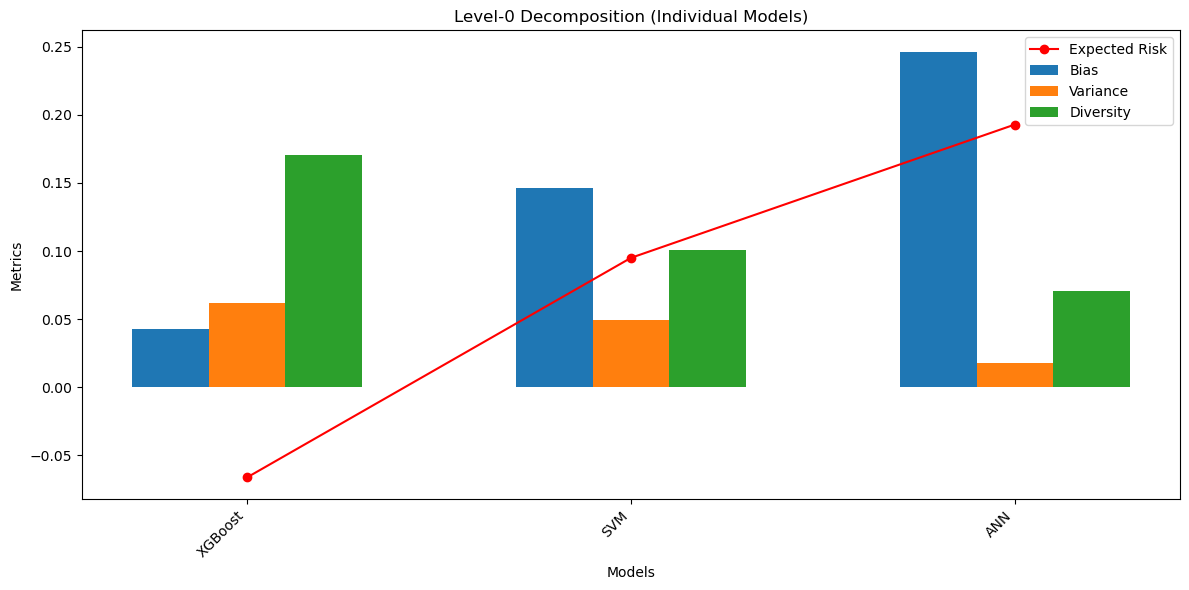

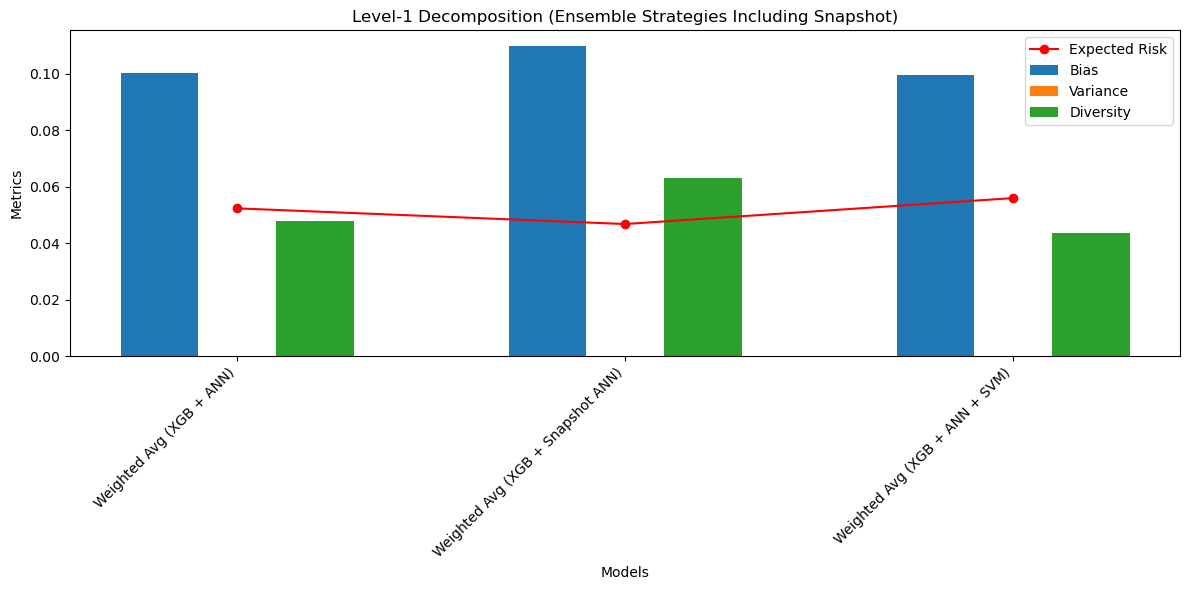

In [38]:
# Updated calculate_decomposition to handle raw predictions
def calculate_decomposition(models, X, y, n_samples=5):
    indices = bootstrap_sample(X, y, n_samples)
    predictions = {model_name: [] for model_name in models}

    for idx_set in indices:
        X_train, y_train = X[idx_set], y[idx_set]
        for model_name, model in models.items():
            if isinstance(model, list):  # Snapshot Ensemble Case
                # Directly use the precomputed snapshot ensemble predictions
                snapshots = model
                snapshot_preds = snapshot_predict(snapshots, X)
                predictions[model_name].append(snapshot_preds)
            elif isinstance(model, np.ndarray):  # Precomputed Predictions (e.g., snapshot_probs)
                predictions[model_name].append(model)
            else:  # Regular scikit-learn model
                model_clone = clone(model)
                model_clone.fit(X_train, y_train)
                predictions[model_name].append(model_clone.predict(X))

    results = {}
    for model_name, preds in predictions.items():
        preds = np.array(preds)
        avg_pred = preds.mean(axis=0)
        bias = np.mean((avg_pred - y) ** 2)
        variance = np.mean(np.var(preds, axis=0))
        diversity = np.mean([np.var([pred for pred in preds]) for pred in preds.T])
        expected_risk = bias + variance - diversity

        results[model_name] = {
            'bias': bias,
            'variance': variance,
            'diversity': diversity,
            'expected_risk': expected_risk
        }
    return results


# Generate Snapshot Ensembles for ANN
snapshots_ann = snapshot_dropout_ensemble(ann_model, X, y, n_snapshots=5, dropout_rate=0.3)

# Get predictions for Snapshot Ensembles
snapshot_probs = snapshot_predict(snapshots_ann, X)  # Precomputed probabilities

# Define Level-0 Models (Individual Models)
models_level_0 = {
    'XGBoost': XGB_model,
    'SVM': svm_model,
    'ANN': ann_model
}

# Define Level-1 Ensembles (Ensemble Strategies)
models_level_1 = {
    'Weighted Avg (XGB + ANN)': np.average(
        [XGB_model.predict_proba(X)[:, 1], ann_model.predict_proba(X)[:, 1]], axis=0, weights=[0.6, 0.4]
    ),
    'Weighted Avg (XGB + Snapshot ANN)': np.average(
        [XGB_model.predict_proba(X)[:, 1], snapshot_probs], axis=0, weights=[0.6, 0.4]
    ),
    'Weighted Avg (XGB + ANN + SVM)': np.average(
        [XGB_model.predict_proba(X)[:, 1], ann_model.predict_proba(X)[:, 1], svm_model.predict_proba(X)[:, 1]],
        axis=0,
        weights=[0.5, 0.3, 0.2]
    )
}

# Level-0 Analysis
level_0_results = calculate_decomposition(models_level_0, X, y)
plot_decomposition(level_0_results, "Level-0 Decomposition (Individual Models)")

# Level-1 Analysis
level_1_results = calculate_decomposition(models_level_1, X, y)
plot_decomposition(level_1_results, "Level-1 Decomposition (Ensemble Strategies Including Snapshot)")


In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
from scikit_posthocs import critical_difference_diagram
from sklearn.metrics import roc_auc_score

# Use probability values for AUC computation
models_probabilities = {
    'XGBoost': XGB_y_prob,
    'SVM': SVM_y_prob,
    'ANN': ANN_y_prob,
    'Weighted Averaging (XGBoost + ANN)': ensemble_probs,  # Weighted averaging
    'Weighted Averaging (XGBoost + ANN + SVM)': weighted_probs  # Weighted averaging with SVM
}

# Compute AUC scores for each model
auc_scores = {model: roc_auc_score(y, probs) for model, probs in models_probabilities.items()}
print("AUC Scores:", auc_scores)

# Prepare data for Friedman Test (convert to list of lists)
scores = list(models_probabilities.values())

# Perform Friedman Test
stat, p_value = friedmanchisquare(*scores)
print(f"Friedman Test Statistic: {stat}, P-value: {p_value}")

# Post-Hoc Conover Test
scores_matrix = np.array(scores).T  # Transpose: rows as observations, columns as models
posthoc = sp.posthoc_conover_friedman(scores_matrix)
print("Conover Post-Hoc Test Results:")
print(posthoc)

# Convert AUC Scores to Ranks
ranked_auc = {model: len(auc_scores) - sorted(auc_scores.values()).index(score) for model, score in auc_scores.items()}



AUC Scores: {'XGBoost': 0.8775125628140704, 'SVM': 0.7703360552763818, 'ANN': 0.8788473618090452, 'Weighted Averaging (XGBoost + ANN)': 0.8754711055276382, 'Weighted Averaging (XGBoost + ANN + SVM)': 0.8731940954773869}
Friedman Test Statistic: 460.614448669201, P-value: 2.2030914558260646e-98
Conover Post-Hoc Test Results:
              0              1              2             3             4
0  1.000000e+00   5.721769e-09   6.486361e-64  3.019112e-11  2.718081e-48
1  5.721769e-09   1.000000e+00  1.349203e-101  5.890186e-34  1.210384e-83
2  6.486361e-64  1.349203e-101   1.000000e+00  2.251322e-28  6.705691e-03
3  3.019112e-11   5.890186e-34   2.251322e-28  1.000000e+00  1.707732e-17
4  2.718081e-48   1.210384e-83   6.705691e-03  1.707732e-17  1.000000e+00


In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
from scikit_posthocs import critical_difference_diagram
from sklearn.metrics import roc_auc_score

# Prepare AUC Scores for Level-0 Models
level_0_probabilities = {
    'XGBoost': XGB_y_prob,
    'SVM': SVM_y_prob,
    'ANN': ANN_y_prob,
}

# Prepare AUC Scores for Level-1 Models
level_1_probabilities = {
    'Weighted Avg (XGB + ANN)': ensemble_probs,
    'Weighted Avg (XGB + ANN + SVM)': weighted_probs,
    'Snapshot + Dropout (ANN)': snapshot_predict(snapshots_ann, X),
}

# Compute AUC Scores for Level-0 Models
level_0_auc = {model: roc_auc_score(y, probs) for model, probs in level_0_probabilities.items()}
print("Level-0 AUC Scores:", level_0_auc)

# Compute AUC Scores for Level-1 Models
level_1_auc = {model: roc_auc_score(y, probs) for model, probs in level_1_probabilities.items()}
print("Level-1 AUC Scores:", level_1_auc)

# Perform Friedman Test for Level-0
level_0_scores = list(level_0_probabilities.values())
level_0_stat, level_0_p_value = friedmanchisquare(*level_0_scores)
print(f"Level-0 Friedman Test Statistic: {level_0_stat}, P-value: {level_0_p_value}")

# Perform Post-Hoc Conover Test for Level-0
level_0_matrix = np.array(level_0_scores).T
level_0_posthoc = sp.posthoc_conover_friedman(level_0_matrix)
print("Level-0 Conover Post-Hoc Test Results:")
print(level_0_posthoc)

# Perform Friedman Test for Level-1
level_1_scores = list(level_1_probabilities.values())
level_1_stat, level_1_p_value = friedmanchisquare(*level_1_scores)
print(f"Level-1 Friedman Test Statistic: {level_1_stat}, P-value: {level_1_p_value}")

# Perform Post-Hoc Conover Test for Level-1
level_1_matrix = np.array(level_1_scores).T
level_1_posthoc = sp.posthoc_conover_friedman(level_1_matrix)
print("Level-1 Conover Post-Hoc Test Results:")
print(level_1_posthoc)

# Helper Function for Ranks and Critical Difference Diagrams
def plot_critical_difference_diagram(auc_scores, posthoc_results, title):
    # Convert AUC Scores to Ranks
    ranked_auc = {model: len(auc_scores) - sorted(auc_scores.values()).index(score) for model, score in auc_scores.items()}
    
    # Plot the Critical Difference Diagram
    plt.figure(figsize=(14, 6))
    critical_difference_diagram(
        ranks=ranked_auc,
        sig_matrix=posthoc_results,
        ax=None,
        label_fmt_left="{label} ({rank:.2g})",
        label_fmt_right="",
        label_props={'fontsize': 12, 'weight': 'bold'},
        marker_props={'s': 100},  # Increase marker size
        crossbar_props={'linewidth': 2.0},  # Make bars thicker
        color_palette=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"],  # Custom colors
        text_h_margin=0.03,  # Add margin between labels and bars
        left_only=True  # Align all labels to one side
    )
    plt.title(title, fontsize=16, weight='bold')
    plt.xlabel("Average Rank", fontsize=14)
    plt.tight_layout()
    plt.show()



Level-0 AUC Scores: {'XGBoost': 0.8775125628140704, 'SVM': 0.7703360552763818, 'ANN': 0.8788473618090452}
Level-1 AUC Scores: {'Weighted Avg (XGB + ANN)': 0.8754711055276382, 'Weighted Avg (XGB + ANN + SVM)': 0.8731940954773869, 'Snapshot + Dropout (ANN)': 0.5295618718592965}
Level-0 Friedman Test Statistic: 283.9011406844106, P-value: 2.2472459031639804e-62
Level-0 Conover Post-Hoc Test Results:
              0             1             2
0  1.000000e+00  6.382598e-13  5.112129e-51
1  6.382598e-13  1.000000e+00  2.452523e-87
2  5.112129e-51  2.452523e-87  1.000000e+00
Level-1 Friedman Test Statistic: 372.874524714829, P-value: 1.0747952465398184e-81
Level-1 Conover Post-Hoc Test Results:
               0             1              2
0   1.000000e+00  1.083135e-46  3.289572e-142
1   1.083135e-46  1.000000e+00   2.287590e-65
2  3.289572e-142  2.287590e-65   1.000000e+00


In [89]:
import numpy as np
import pandas as pd
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
from sklearn.metrics import f1_score, accuracy_score

# Define predictions and ground truth
y = np.array(y)  # Ground truth
XGB_y_pred = np.array(XGB_y_pred)  # Predictions for XGBoost
SVM_y_pred = np.array(SVM_y_pred)  # Predictions for SVM
ANN_y_pred = np.array(ANN_y_pred)  # Predictions for ANN
ensemble_preds = np.array(ensemble_preds)  # Predictions for Weighted Avg (XGB + ANN)
weighted_preds = np.array(weighted_preds)  # Predictions for Weighted Avg (XGB + ANN + SVM)
snapshot_preds = np.array(snapshot_preds)  # Predictions for Snapshot + Dropout (ANN)

# Level-0 models
level_0_probabilities = {
    'XGBoost': XGB_y_pred,
    'SVM': SVM_y_pred,
    'ANN': ANN_y_pred,
}

# Level-1 models
level_1_probabilities = {
    'Weighted Avg (XGB + ANN)': ensemble_preds,
    'Weighted Avg (XGB + ANN + SVM)': weighted_preds,
    'Snapshot + Dropout (ANN)': snapshot_preds,
}

# Calculate F1 Scores for Level-0 Models
level_0_f1_scores = {model: f1_score(y, preds, average='weighted') for model, preds in level_0_probabilities.items()}
print("Level-0 F1 Scores:", level_0_f1_scores)

# Calculate F1 Scores for Level-1 Models
level_1_f1_scores = {model: f1_score(y, preds, average='weighted') for model, preds in level_1_probabilities.items()}
print("Level-1 F1 Scores:", level_1_f1_scores)

# Perform Friedman Test for Level-0
level_0_f1_values = list(level_0_probabilities.values())
level_0_stat, level_0_p_value = friedmanchisquare(*level_0_f1_values)
print(f"Level-0 Friedman Test Statistic: {level_0_stat}, P-value: {level_0_p_value}")

# Perform Post-Hoc Conover Test for Level-0
level_0_f1_matrix = np.array(level_0_f1_values).T
level_0_posthoc = sp.posthoc_conover_friedman(level_0_f1_matrix)
print("Level-0 Conover Post-Hoc Test Results:")
print(level_0_posthoc)

# Perform Friedman Test for Level-1
level_1_f1_values = list(level_1_probabilities.values())
level_1_stat, level_1_p_value = friedmanchisquare(*level_1_f1_values)
print(f"Level-1 Friedman Test Statistic: {level_1_stat}, P-value: {level_1_p_value}")

# Perform Post-Hoc Conover Test for Level-1
level_1_f1_matrix = np.array(level_1_f1_values).T
level_1_posthoc = sp.posthoc_conover_friedman(level_1_f1_matrix)
print("Level-1 Conover Post-Hoc Test Results:")
print(level_1_posthoc)


Level-0 F1 Scores: {'XGBoost': 0.8124567705621821, 'SVM': 0.6889225322633193, 'ANN': 0.8316142737285565}
Level-1 F1 Scores: {'Weighted Avg (XGB + ANN)': 0.8945913208941614, 'Weighted Avg (XGB + ANN + SVM)': 0.8981632415807078, 'Snapshot + Dropout (ANN)': 0.6847906108070446}
Level-0 Friedman Test Statistic: 105.85999999999935, P-value: 1.0298952920430646e-23
Level-0 Conover Post-Hoc Test Results:
              0             1             2
0  1.000000e+00  3.318613e-08  7.253772e-09
1  3.318613e-08  1.000000e+00  2.100422e-27
2  7.253772e-09  2.100422e-27  1.000000e+00
Level-1 Friedman Test Statistic: 49.36842105263091, P-value: 1.9045114073845333e-11
Level-1 Conover Post-Hoc Test Results:
              0             1             2
0  1.000000e+00  8.650039e-01  2.343971e-10
1  8.650039e-01  1.000000e+00  6.567684e-10
2  2.343971e-10  6.567684e-10  1.000000e+00


In [90]:
import numpy as np
import pandas as pd
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
from sklearn.metrics import accuracy_score

# Define predictions and ground truth
y = np.array(y)  # Ground truth
XGB_y_pred = np.array(XGB_y_pred)  # Predictions for XGBoost
SVM_y_pred = np.array(SVM_y_pred)  # Predictions for SVM
ANN_y_pred = np.array(ANN_y_pred)  # Predictions for ANN
ensemble_preds = np.array(ensemble_preds)  # Predictions for Weighted Avg (XGB + ANN)
weighted_preds = np.array(weighted_preds)  # Predictions for Weighted Avg (XGB + ANN + SVM)
snapshot_preds = np.array(snapshot_preds)  # Predictions for Snapshot + Dropout (ANN)

# Level-0 models
level_0_probabilities = {
    'XGBoost': XGB_y_pred,
    'SVM': SVM_y_pred,
    'ANN': ANN_y_pred,
}

# Level-1 models
level_1_probabilities = {
    'Weighted Avg (XGB + ANN)': ensemble_preds,
    'Weighted Avg (XGB + ANN + SVM)': weighted_preds,
    'Snapshot + Dropout (ANN)': snapshot_preds,
}

# Calculate Accuracy Scores for Level-0 Models
level_0_accuracy_scores = {model: accuracy_score(y, preds) for model, preds in level_0_probabilities.items()}
print("Level-0 Accuracy Scores:", level_0_accuracy_scores)

# Calculate Accuracy Scores for Level-1 Models
level_1_accuracy_scores = {model: accuracy_score(y, preds) for model, preds in level_1_probabilities.items()}
print("Level-1 Accuracy Scores:", level_1_accuracy_scores)

# Perform Friedman Test for Level-0
level_0_accuracy_values = list(level_0_probabilities.values())
level_0_stat, level_0_p_value = friedmanchisquare(*level_0_accuracy_values)
print(f"Level-0 Friedman Test Statistic: {level_0_stat}, P-value: {level_0_p_value}")

# Perform Post-Hoc Conover Test for Level-0
level_0_accuracy_matrix = np.array(level_0_accuracy_values).T
level_0_posthoc = sp.posthoc_conover_friedman(level_0_accuracy_matrix)
print("Level-0 Conover Post-Hoc Test Results:")
print(level_0_posthoc)

# Perform Friedman Test for Level-1
level_1_accuracy_values = list(level_1_probabilities.values())
level_1_stat, level_1_p_value = friedmanchisquare(*level_1_accuracy_values)
print(f"Level-1 Friedman Test Statistic: {level_1_stat}, P-value: {level_1_p_value}")

# Perform Post-Hoc Conover Test for Level-1
level_1_accuracy_matrix = np.array(level_1_accuracy_values).T
level_1_posthoc = sp.posthoc_conover_friedman(level_1_accuracy_matrix)
print("Level-1 Conover Post-Hoc Test Results:")
print(level_1_posthoc)


Level-0 Accuracy Scores: {'XGBoost': 0.8060836501901141, 'SVM': 0.6653992395437263, 'ANN': 0.8479087452471483}
Level-1 Accuracy Scores: {'Weighted Avg (XGB + ANN)': 0.8973384030418251, 'Weighted Avg (XGB + ANN + SVM)': 0.9011406844106464, 'Snapshot + Dropout (ANN)': 0.7452471482889734}
Level-0 Friedman Test Statistic: 105.85999999999935, P-value: 1.0298952920430646e-23
Level-0 Conover Post-Hoc Test Results:
              0             1             2
0  1.000000e+00  3.318613e-08  7.253772e-09
1  3.318613e-08  1.000000e+00  2.100422e-27
2  7.253772e-09  2.100422e-27  1.000000e+00
Level-1 Friedman Test Statistic: 49.36842105263091, P-value: 1.9045114073845333e-11
Level-1 Conover Post-Hoc Test Results:
              0             1             2
0  1.000000e+00  8.650039e-01  2.343971e-10
1  8.650039e-01  1.000000e+00  6.567684e-10
2  2.343971e-10  6.567684e-10  1.000000e+00


Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


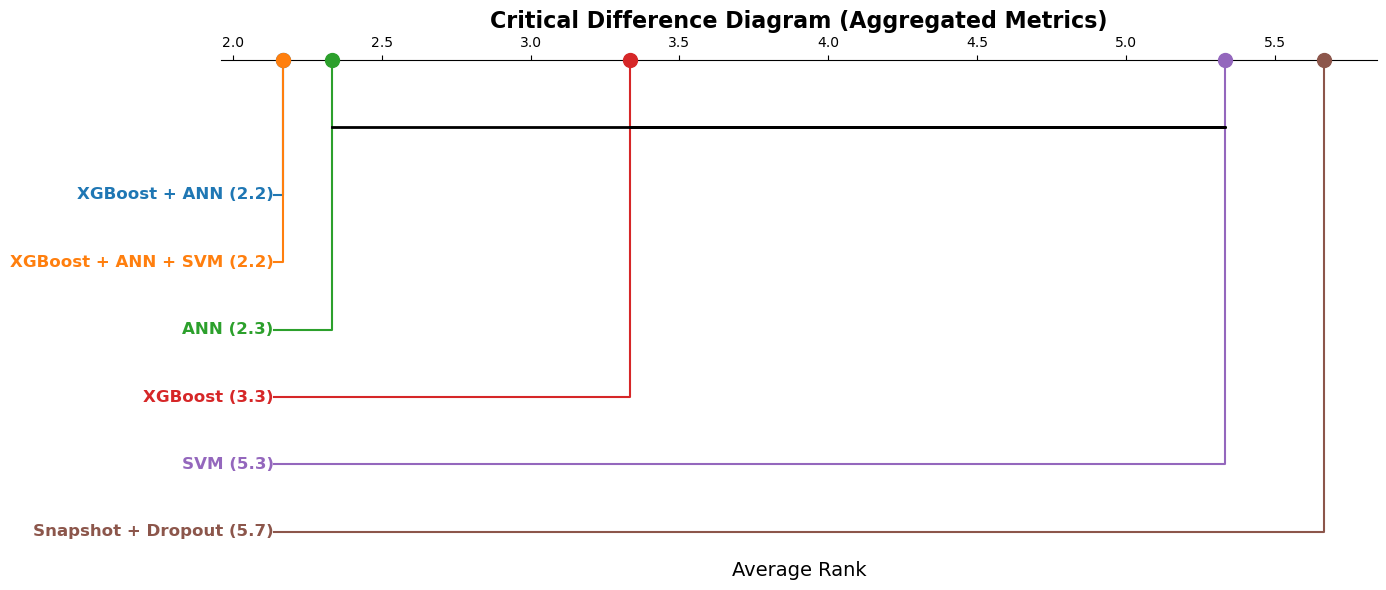

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
from scikit_posthocs import critical_difference_diagram

# Define metrics for each model
metrics = ['AUC', 'F1 Score', 'Accuracy']
scores = {
    'XGBoost': [0.8775, 0.8125, 0.81],
    'SVM': [0.7703, 0.6889, 0.67],
    'ANN': [0.8788, 0.8316, 0.85],
    'XGBoost + ANN': [0.8755, 0.8946, 0.90],
    'XGBoost + ANN + SVM': [0.8732, 0.8982, 0.90],
    'Snapshot + Dropout': [0.5296, 0.6848, 0.7452],
}

# Calculate ranks for each metric
df_scores = pd.DataFrame(scores, index=metrics)
df_ranks = df_scores.rank(axis=1, ascending=False)
average_ranks = df_ranks.mean(axis=0)

# Convert average ranks into a dictionary for CD diagram
ranked_auc = average_ranks.to_dict()

# Plot Critical Difference Diagram
plt.figure(figsize=(14, 6))
critical_difference_diagram(
    ranks=ranked_auc,
    sig_matrix=posthoc,
    ax=None,
    label_fmt_left="{label} ({rank:.2g})",
    label_fmt_right="",
    label_props={'fontsize': 12, 'weight': 'bold'},
    marker_props={'s': 100},  # Increase marker size
    crossbar_props={'linewidth': 2.0},  # Make bars thicker
    color_palette=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"],  # Custom colors
    text_h_margin=0.03,  # Add margin between labels and bars
    left_only=True  # Align all labels to one side
)
plt.title("Critical Difference Diagram (Aggregated Metrics)", fontsize=16, weight='bold')
plt.xlabel("Average Rank", fontsize=14)
plt.tight_layout()
plt.show()


Friedman Test Statistic: 11.249999999999995, P-value: 0.0466424435627677
Conover Post-Hoc Test Results:
     0    1    2
0  1.0  1.0  1.0
1  1.0  1.0  1.0
2  1.0  1.0  1.0


Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


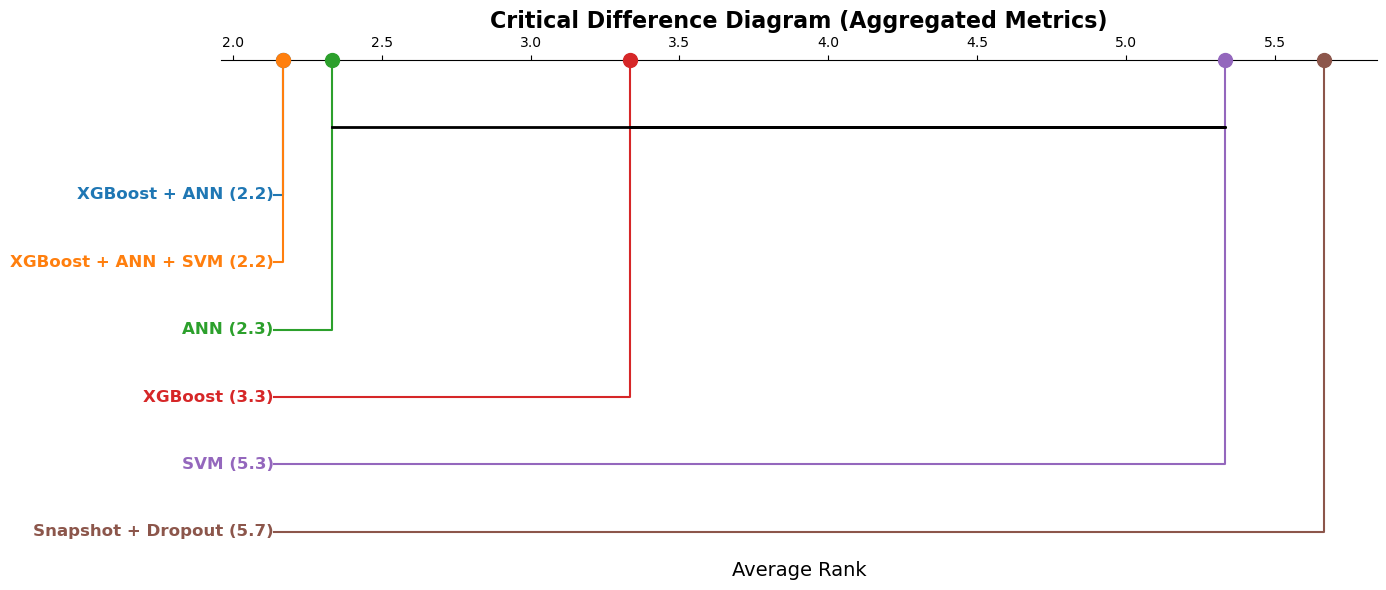

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
from scikit_posthocs import critical_difference_diagram

# Define metrics for each model
metrics = ['AUC', 'F1 Score', 'Accuracy']
scores = {
    'XGBoost': [0.8775, 0.8125, 0.81],
    'SVM': [0.7703, 0.6889, 0.67],
    'ANN': [0.8788, 0.8316, 0.85],
    'XGBoost + ANN': [0.8755, 0.8946, 0.90],
    'XGBoost + ANN + SVM': [0.8732, 0.8982, 0.90],
    'Snapshot + Dropout': [0.5296, 0.6848, 0.7452],
}

# Calculate ranks for each metric
df_scores = pd.DataFrame(scores, index=metrics)
df_ranks = df_scores.rank(axis=1, ascending=False)
average_ranks = df_ranks.mean(axis=0)

# Perform Friedman Test
stat, p_value = friedmanchisquare(*df_ranks.values.T)
print(f"Friedman Test Statistic: {stat}, P-value: {p_value}")

# Perform Post-Hoc Conover Test
matrix = df_ranks.values.T
posthoc = sp.posthoc_conover_friedman(matrix)
print("Conover Post-Hoc Test Results:")
print(posthoc)

# Convert average ranks into a dictionary for CD diagram
ranked_auc = average_ranks.to_dict()

# Plot Critical Difference Diagram
plt.figure(figsize=(14, 6))
critical_difference_diagram(
    ranks=ranked_auc,
    sig_matrix=posthoc,
    ax=None,
    label_fmt_left="{label} ({rank:.2g})",
    label_fmt_right="",
    label_props={'fontsize': 12, 'weight': 'bold'},
    marker_props={'s': 100},  # Increase marker size
    crossbar_props={'linewidth': 2.0},  # Make bars thicker
    color_palette=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"],  # Custom colors
    text_h_margin=0.03,  # Add margin between labels and bars
    left_only=True  # Align all labels to one side
)
plt.title("Critical Difference Diagram (Aggregated Metrics)", fontsize=16, weight='bold')
plt.xlabel("Average Rank", fontsize=14)
plt.tight_layout()
plt.show()


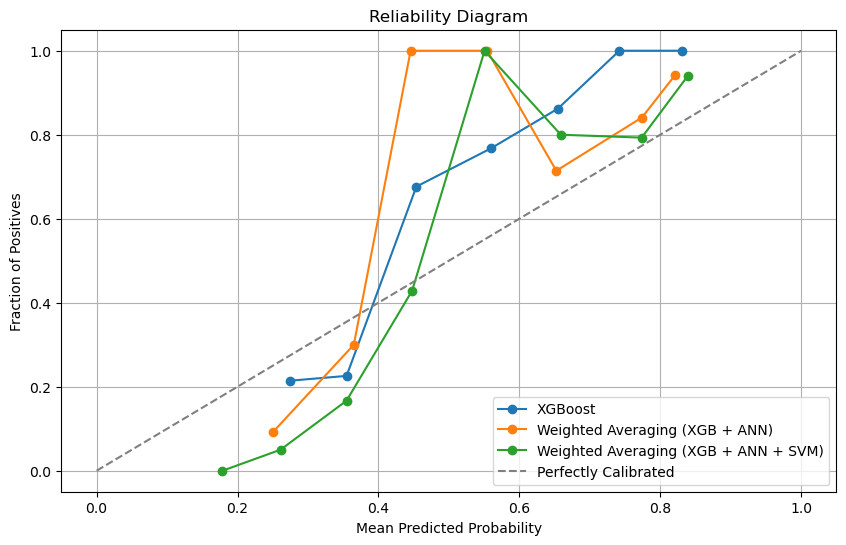

In [17]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Reliability Diagram for Ensembles
def plot_reliability_diagram(y_true, model_probs, model_labels):
    plt.figure(figsize=(10, 6))
    for probs, label in zip(model_probs, model_labels):
        fraction_of_positives, mean_predicted_value = calibration_curve(y_true, probs, n_bins=10, strategy='uniform')
        plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label=label)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Reliability Diagram')
    plt.legend()
    plt.grid()
    plt.show()

# Example Usage
model_probs = [XGB_y_prob, ensemble_probs, weighted_probs]
model_labels = ['XGBoost', 'Weighted Averaging (XGB + ANN)', 'Weighted Averaging (XGB + ANN + SVM)']
plot_reliability_diagram(y, model_probs, model_labels)


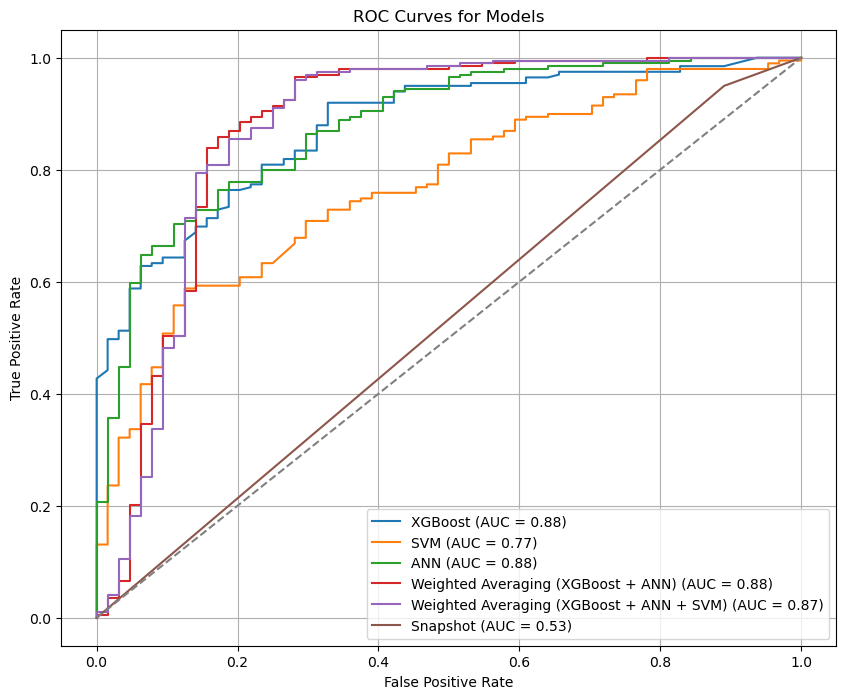

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Generate ROC curve data
models_data = {
    'XGBoost': XGB_y_prob,
    'SVM': SVM_y_prob,
    'ANN': ANN_y_prob,
    'Weighted Averaging (XGBoost + ANN)': ensemble_probs,
    'Weighted Averaging (XGBoost + ANN + SVM)': weighted_probs,
    'Snapshot': snapshot_probs
}

# Assuming `y` is the true labels
roc_curves = {}

for model_name, y_prob in models_data.items():
    fpr, tpr, _ = roc_curve(y, y_prob)
    roc_auc = auc(fpr, tpr)
    roc_curves[model_name] = {
        'fpr': fpr,
        'tpr': tpr,
        'auc': roc_auc
    }

# Plot ROC curves
plt.figure(figsize=(10, 8))
for model_name, data in roc_curves.items():
    plt.plot(data['fpr'], data['tpr'], label=f"{model_name} (AUC = {data['auc']:.2f})")

# Add diagonal line for random guessing
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Configure plot
plt.title('ROC Curves for Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()
